# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Libraries

In [2]:
!pip install torchmetrics

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/CV/Project/Code')

import random
import json
import torch
import pickle
import os
import torch.nn as nn
import numpy as np
from models import GbcNet
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import copy
import time
import math
import cv2
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms import Resize, ToTensor, Compose, GaussianBlur
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.nn.init as init
from torch.optim import SGD, Adam, NAdam
from torchmetrics.detection import MeanAveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import one_hot

from sklearn.metrics import roc_auc_score

from torchvision.utils import draw_bounding_boxes
import torchvision
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### File Paths

In [4]:
#!unzip "/content/drive/MyDrive/CV/Project/data/images.zip" -d "/content"
imgs_folder_path = "/content/images"
train_txt_path = "/content/drive/MyDrive/CV/Project/data/train.txt" # Original train dataset
#train_txt_path = "/content/drive/MyDrive/CV/Project/data/augmented_train.txt" # Flipped malignant images for total balanced dataset
#train_txt_path = "/content/drive/MyDrive/CV/Project/data/train_double_malignant.txt" # Rotated malignant images for total balanced dataset
#train_txt_path = "/content/drive/MyDrive/CV/Project/data/train_nr.txt" # Only rotated normal images to be balanced with sum of malignant and benign
#train_txt_path = "/content/drive/MyDrive/CV/Project/data/train_nmr.txt" # rotated malignanet to be equal to benign, rotated normal to be equal to benign+malignant, 3 and 6 degrees rotation
#train_txt_path = "/content/drive/MyDrive/CV/Project/data/train_nmr_2.txt" # rotated malignanet to be equal to benign, rotated normal to be equal to benign+malignant, 3 and -3 degrees rotation
val_txt_path = "/content/drive/MyDrive/CV/Project/data/test.txt"
gold_file_path = "/content/drive/MyDrive/CV/Project/data/gold_boxes.json"
gbcnet_weight_path = "/content/drive/MyDrive/CV/Project/Code/Original Models/init_weights.pth"

#train_txt_path = "/content/drive/MyDrive/CV/Project/data/train val test split/temp.txt"
#val_txt_path = "/content/drive/MyDrive/CV/Project/data/train val test split/temp.txt"

### Helper Functions

In [5]:
def read_txt(txt_path):
  ids = []
  cls = []
  with open(txt_path,"r") as f:
    for line in f.readlines():
      ids.append(line.strip().split(',')[0])
      cls.append(int(line.strip().split(',')[1]))

  return ids, cls

def read_json(json_path):
  with open(json_path, "r") as f:
    json_file = json.load(f)

  return json_file

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(img, pred_bboxes=None, title=None):
    print("visualize")
    edgecolors = ["y", "r", "c"]
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the original image with bounding box
    if torch.is_tensor(img):
      ax.imshow(img.permute(1, 2, 0).numpy())
    else:
      ax.imshow(img)
    if pred_bboxes is not None:
      for i in range(len(pred_bboxes)):
        pred_bbox = pred_bboxes[i]
        rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], linewidth=2, edgecolor=edgecolors[i], facecolor='none')
        ax.add_patch(rect)
    ax.set_title(title)

    plt.show()


def gold_box_proportion(x):
  if x < 30:
    return 1
  elif 30 <= x < 35:
    return 0.75
  elif 35 <= x < 40:
    return 0.5
  elif 40 <= x < 45:
    return 0.25
  else:
    return 0

def print_status(txt, status_flag):
  if status_flag==False:
    print(txt)
  return True

def filter_background(predictions):
  # Filter out the predictions with label 0
  filtered_predictions = []
  for prediction in predictions:
      mask = prediction['labels'] != 0
      filtered_prediction = {k: v[mask] for k, v in prediction.items()}
      filtered_predictions.append(filtered_prediction)
  return filtered_predictions

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Transforms

In [6]:
class img_bbox_transform(object):
    def __init__(self, target_width, target_height):
      self.target_width = target_width
      self.target_height = target_height
      self.transforms = Compose([Resize((self.target_width, self.target_height)),
                                ToTensor()])

    def __call__(self, image=None, bbox = None, current_width=None, current_height=None):
      transformed_image = None
      if image is not None:
        current_width, current_height = image.size
        transformed_image = self.transforms(image)
      transformed_bbox = None
      if bbox is not None:
        transformed_bbox = self.transform_bbox(bbox, current_width, current_height)
      return transformed_image, transformed_bbox

    def transform_bbox(self, bbox, current_width=None, current_height=None):
      new_x1 = bbox[0]*self.target_width/current_width
      new_y1 = bbox[1]*self.target_height/current_height
      new_x2 = bbox[2]*self.target_width/current_width
      new_y2 = bbox[3]*self.target_height/current_height
      return [round(new_x1.item()), round(new_y1.item()), round(new_x2.item()), round(new_y2.item())]


def crop_image(image, box, p):
    x1, y1, x2, y2 = box
    # Recieves images in format CHW
    cropped_image = image[:, int((1-p)*y1):int((1+p)*y2), int((1-p)*x1):int((1+p)*x2)]
    return cropped_image

def get_train_transforms(width, height, p=None):
    return A.Compose([
        A.Rotate(limit=5, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.6, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit= 0.1, p=0.5),
        A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=5, val_shift_limit=0, p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
        A.Perspective(scale=(0.01, 0.05), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.7),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
        A.Resize(height=height, width=width, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_eval_transforms(width, height):
    return A.Compose([
        A.Resize(height=height, width=width, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

### Dataset

In [7]:
class InputDataset(Dataset):
    def __init__(self, img_folder, id_txt, gold_json, p=0.15, width=224, height=224, img_transforms=None, do_crop=None, predicted_bboxes_json=None, to_blur=False, blur_kernel_size=(65,65), sigma=0):
        self.img_folder = img_folder
        self.id_txt = id_txt
        self.gold_json = gold_json
        self.to_blur = to_blur
        self.blur_kernel_size = blur_kernel_size
        self.sigma = sigma
        self.do_crop=do_crop
        self.p=p
        self.width=width
        self.height=height
        self.transforms = img_transforms
        self.ids, self.true_labels = read_txt(id_txt)
        self.gold_dict = read_json(gold_json)
        self.predicted_boxes = None
        if predicted_bboxes_json is not None:
          self.predicted_boxes=read_json(predicted_bboxes_json)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_label = self.true_labels[idx]
        gold_bbox = self.gold_dict[img_id]['Gold']
        img_path = f"{self.img_folder}/{img_id}"
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape
        if self.to_blur:
          img = cv2.GaussianBlur(img, self.blur_kernel_size, self.sigma)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if (self.do_crop==None) or (self.do_crop=="gold_boxes"):
          transformed_dict = self.transforms(image=img, bboxes=[gold_bbox], labels=[1])
        elif self.do_crop=="pred_boxes":
          pred_bbox = self.predicted_boxes[img_id]['Boxes']
          transformed_dict = self.transforms(image=img, bboxes=[pred_bbox], labels=[1])

        #visualize(img, pred_bboxes=[gold_bbox, pred_bbox], title=f"raw image {img_id}")
        transformed_img = transformed_dict['image'].float().div(255)
        transformed_bboxes = [round(x) for x in transformed_dict['bboxes'][0]]
        #visualize(transformed_img, [[0,0,0,0], transformed_bboxes], title=f"transformed img {img_id}")

        if self.do_crop is not None:
          transformed_bboxes_area = (transformed_bboxes[2]-transformed_bboxes[0]) * (transformed_bboxes[3]-transformed_bboxes[1])
          if transformed_bboxes_area > 0:
            transformed_img = crop_image(transformed_img, transformed_bboxes, p=self.p)
            transformed_img = F.interpolate(transformed_img.unsqueeze(0), size=(self.height, self.width), mode='bilinear', align_corners=False).squeeze(0)

        #visualize(transformed_img, title=f"cropped img {img_id}")

        target = {}
        target['boxes'] = torch.tensor(transformed_bboxes).unsqueeze(0)
        target['labels'] = torch.tensor(1).unsqueeze(0)
        target['true_labels'] = torch.tensor(img_label, dtype=torch.int64)
        target['image shape'] = {'height': img_height, 'width': img_width}
        target['Gold'] = gold_bbox
        return img_id, transformed_img, target

def collate_fn(batch):
  images_ids, images, targets = zip(*batch)
  return list(images_ids), list(images), list(targets)

### Evaluation

In [8]:
def compute_IoU(boxA, boxB):
  x1_A, y1_A, x2_A, y2_A = boxA
  x1_B, y1_B, x2_B, y2_B = boxB

  x1 = max(x1_A, x1_B)
  y1 = max(y1_A, y1_B)
  x2 = min(x2_A, x2_B)
  y2 = min(y2_A, y2_B)

  if x2 <= x1 or y2 <= y1:
    return torch.tensor(0).to(device)

  intersection_area = (x2 - x1) * (y2 - y1)
  boxA_area = (x2_A - x1_A) * (y2_A - y1_A)
  boxB_area = (x2_B - x1_B) * (y2_B - y1_B)

  iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
  return iou.float()

def center_within_gold(box, gold):
  x_center = (box[0] + box[2])/2
  y_center = (box[1] + box[3])/2
  x_min_gold, x_max_gold = gold[0], gold[2]
  y_min_gold, y_max_gold = gold[1], gold[3]
  if (x_min_gold<x_center<x_max_gold) and (y_min_gold<y_center<y_max_gold):
    return True
  else:
    return False

def compute_bbox_metrics(targets, predictions):
  tp = 0
  fp = 0
  fn = 0
  for i in range(len(predictions)):
    target_box = targets[i]['boxes'][0]
    pred_boxes = predictions[i]['boxes']
    if len(pred_boxes) > 0:
      for pred_box in pred_boxes:
        if center_within_gold(pred_box, target_box):
          tp += 1
        else:
          fp += 1
    else:
      fn += 1
  return tp, fp, fn

def evaluate_IoUs(targets, predictions):
  IoUs = []
  for i in range(len(predictions)):
    target_box = targets[i]['boxes'][0]
    pred_boxes = predictions[i]['boxes']
    if len(pred_boxes) > 0:
      for pred_box in pred_boxes:
        IoUs.append(compute_IoU(target_box, pred_box.squeeze(0)))
    else:
      IoUs.append(torch.tensor(0.0).to(device))
  return IoUs

# GBCRet

## Evaluation

In [13]:
def evaluate_model(model, dataloader, return_bboxes=False):
  model.eval()
  all_IoUs = []
  mAP_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
  y_pred = []
  y_true = []
  fnames = []
  TPs = 0
  FNs = 0
  FPs = 0
  precision = 0
  recall = 0
  all_bboxes= {}
  all_logits = [[], []]
  with torch.inference_mode():
    for i, data in enumerate(dataloader, 0):
      images_ids, inputs, targets = data[0],\
                                    [image.to(device) for image in data[1]],\
                                    [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in data[2]]

      pred_cls, pred_bboxes, logits = model(inputs, targets)

      logits = [x.tolist() for x in logits]
      all_logits = [a+b for a, b in zip(all_logits, logits)]
      y_true += [x['true_labels'].item() for x in targets]
      y_pred += pred_cls.tolist()
      fnames += images_ids

      IoUs = evaluate_IoUs(targets, pred_bboxes)
      all_IoUs += IoUs

      tp, fp, fn = compute_bbox_metrics(targets, pred_bboxes)
      TPs += tp
      FPs += fp
      FNs += fn

      mAP_metric.update(pred_bboxes, targets)

      if return_bboxes:
        for i in range(len(targets)):
          fname = images_ids[i]
          target_bbox = targets[i]['boxes']
          pred_bbox = pred_bboxes[i]['boxes']
          all_bboxes[fname] = {"Boxes": pred_bbox, "Gold": target_bbox}

  mIoU = torch.stack(all_IoUs).mean()
  medIoU = torch.stack(all_IoUs).median()
  mAP_dict = mAP_metric.compute()
  mAP = mAP_dict['map']
  print(f"mIoU = {mIoU}, median IoU: {medIoU}, mAP = {round(mAP_dict['map'].item(),3)}, mAP_50 = {round(mAP_dict['map_50'].item(),3)}, mAP_75 = {round(mAP_dict['map_75'].item(),3)}")

  if (TPs + FPs) != 0:
    precision = TPs / (TPs + FPs)
  if (TPs + FNs) != 0:
    recall = TPs / (TPs + FNs)
  print(f"TP: {TPs}, FN: {FNs}, FP: {FPs}")
  print("Precision: {}\nRecall: {}".format(precision, recall))

  acc = accuracy_score(y_true, y_pred)
  cfm = confusion_matrix(y_true, y_pred)
  spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
  sens = cfm[2][2]/np.sum(cfm[2])
  print('Acc: {:.4f} Spec: {:.4f} Sens: {:.4f}'.format(acc, spec, sens))

  return acc, round(mAP_dict['map'].item(),3), cfm, y_true, y_pred, fnames, all_bboxes, all_logits

## Model

### Attention

In [10]:
class FeatureMapAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.multiheadattn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

  def forward(self, feature_map):
    # feature map shape: [batch_size, 256, H, W]
    # Reshape to: [batch_size, H*W, 256]
    x = feature_map.reshape(feature_map.size(0), -1, 256)
    # Apply Attention
    attn_output, _ = self.multiheadattn(x,x,x)
    # Reshape back to original shape: [batch_size, 256, H, W]
    return attn_output.reshape(*feature_map.shape)

class VectorAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.multiheadattn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

  def forward(self, x):
    # x shape: [batch_size, 256 + 2048]
    # Reshape to: [batch_size, 1, 256 + 2048]
    x = x.unsqueeze(1)
    # Apply Attention
    attn_output, _ = self.multiheadattn(x, x, x)
    # Remove the extra dimension: [batch_size, 256 + 2048]
    return attn_output.squeeze(1)


### Main model

In [11]:
class GBCRet_combined(nn.Module):
  def __init__(self, combined="None", continue_training=False, criterion=None, gbcnet_weight_path=None, retinanet_weight_path=None,
               do_hierarchical_cls=False, retinanet_backbone="resnet50-coco", gold_curriculum=False, p=0.15, width=224, height=224,
               attn_num_heads=4, no_attn=True, train_gold_bbox=True, min_size=800, max_size=1333, dropout=0.4, detections_per_img=1,
               regression_loss=None, rn_trainable_layers=None, gbcnet_va_curriculum=False, load_pretrained_retinanet=False,
               nnn_fc_layers="1", bm_fc_layers="1", return_logits=True,
               loss_weights = {"n_nn_loss_weight": 1.0, "b_m_loss_weight": 1.0, "classification_loss_weight": 1.0, "retinanet_loss_weight": 1.0}):
    super(GBCRet_combined, self).__init__()
    # Settings
    self.return_logits=return_logits
    self.loss_weights=loss_weights
    self.load_pretrained_retinanet=load_pretrained_retinanet
    self.gbcnet_va_curriculum=gbcnet_va_curriculum
    self.rn_trainable_layers=rn_trainable_layers
    self.retinanet_backbone=retinanet_backbone
    self.combined=combined
    self.no_attn = no_attn
    self.do_hierarchical_cls=do_hierarchical_cls
    self.continue_training=continue_training
    self.detections_per_img=detections_per_img
    self.p = p
    self.width = width
    self.height = height
    self.min_size = min_size
    self.max_size = max_size
    self.criterion = criterion
    self.train_gold_bbox = train_gold_bbox
    self.gold_curriculum = gold_curriculum
    self.regression_loss = regression_loss
    self.current_epoch = -1
    if isinstance(dropout, dict):
      n_nn_dropout=dropout['n_nn_dropout']
      b_m_dropout=dropout['b_m_dropout']
      dropout=0
      print(f"n_nn_dropout: {n_nn_dropout}, b_m_dropout: {b_m_dropout}")
    else:
      n_nn_dropout=dropout
      b_m_dropout=dropout
    # Status Flags
    self.gbcnet_va_curriculum_flag=False
    self.combined_status_flag=False
    self.no_attn_status_flag=False
    self.train_gold_box_status_flag=False
    self.gold_curriculum_status_flag=False
    self.num_gold_boxes_status_flag=False
    self.hierarchical_classification_status_flag=False
    # Loading models
    self.retinanet = self.load_retinanet(retinanet_weight_path)
    self.gbcnet = self.load_gbcnet(gbcnet_weight_path)
    # Hooks
    self.retinanet_features = None
    self.gbcnet_features = None
    self.resnet_layer1_features = None
    self.resnet_layer2_features = None
    self.resnet_layer3_features = None
    self.resnet_layer4_features = None
    self.gbcnet.net.layer4.register_forward_hook(self._get_gbcnet_features_hook)
    self.retinanet.backbone.register_forward_hook(self._get_retinanet_features_hook)
    self.retinanet.backbone.body.layer1.register_forward_hook(self._get_resnet_layer1_features_hook)
    self.retinanet.backbone.body.layer2.register_forward_hook(self._get_resnet_layer2_features_hook)
    self.retinanet.backbone.body.layer3.register_forward_hook(self._get_resnet_layer3_features_hook)
    self.retinanet.backbone.body.layer4.register_forward_hook(self._get_resnet_layer4_features_hook)
    # Layers
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.feature_map_attn = FeatureMapAttention(embed_dim=256, num_heads=attn_num_heads)
    self.combined_attn_layer = VectorAttention(embed_dim= 2048 + 256, num_heads=attn_num_heads)

    self.fc = nn.Sequential(
                  nn.Linear((2048 + 256), 256),
                  nn.ReLU(inplace=True),
                  nn.Dropout(dropout),
                  nn.Linear(256, 3)
                )
    self.FPN_linear = nn.Linear(5*256, 256)
    self.Layer2_linear = nn.Linear(512, 256)
    self.Layer3_linear = nn.Linear(1024, 256)
    self.Layer4_linear = nn.Linear(2048, 256)
    self.compress_combined_featuers_linear = nn.Linear((2048 + 256), 2048)

    self.fc2 = nn.Sequential(
                  nn.Linear((5*256), 256),
                  nn.ReLU(inplace=True),
                  nn.Dropout(dropout),
                  nn.Linear(256, 3)
                )
    self.meta_learner = nn.Linear(6,3)

    if nnn_fc_layers=="1":
      self.normal_notnormal_fc = nn.Sequential(
                                            nn.Linear(2048, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(n_nn_dropout),
                                            nn.Linear(256,2)
                                          )
    elif nnn_fc_layers=="3":
      self.normal_notnormal_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(n_nn_dropout),
                                            nn.Linear(512,2)
                                          )
    if bm_fc_layers == "1":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(256,2)
                                          )
    elif bm_fc_layers == "2":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(dropout),
                                            nn.Linear(512, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(256, 2)
                                          )
    elif bm_fc_layers == "3":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(512,2)
                                          )
    elif bm_fc_layers == "4":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 1024),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(1024,2)
                                          )

  def load_retinanet(self, retinanet_weight_path):
    if self.retinanet_backbone=="resnet50-gbusv":
      # No weights -> by default trainable_layers = 5 - https://github.com/pytorch/vision/blob/b1123cfd543d35d282de9bb28067e48ebec18afe/torchvision/models/detection/retinanet.py#L879
      retinanet = retinanet_resnet50_fpn_v2(num_classes=2, detections_per_img = self.detections_per_img, score_thresh=0.05,
                                            nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size).to(device)
      if not self.continue_training:
        retinanet.load_state_dict(torch.load(retinanet_weight_path, map_location=device))
        print(f"Retinanet's GBUSV pre-trained weights are loaded from: {retinanet_weight_path}")
      return retinanet
    elif self.retinanet_backbone=="resnet50-coco":
      if self.rn_trainable_layers == None:
        # Defined weights -> by default trainable layers = 3 - https://github.com/pytorch/vision/blob/b1123cfd543d35d282de9bb28067e48ebec18afe/torchvision/models/detection/retinanet.py#L879
        retinanet = retinanet_resnet50_fpn_v2(weights="COCO_V1", detections_per_img=self.detections_per_img, score_thresh=0.05,
                                              nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size).to(device)
      else:
        print(f"Retinanet's Trainable Backbone Layers: {self.rn_trainable_layers}")
        retinanet = retinanet_resnet50_fpn_v2(weights="COCO_V1", detections_per_img=self.detections_per_img, score_thresh=0.05,
                                              nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size,
                                              trainable_backbone_layers=self.rn_trainable_layers).to(device)
      print("Retinanet's COCO pre-trained weights are loaded.")
      num_classes=2
      num_anchors = retinanet.head.classification_head.num_anchors
      in_channels = retinanet.head.classification_head.cls_logits.in_channels
      new_cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1).to(device)
      torch.nn.init.normal_(new_cls_logits.weight, std=0.01)
      torch.nn.init.constant_(new_cls_logits.bias, -math.log((1 - 0.01) / 0.01))
      retinanet.head.classification_head.cls_logits = new_cls_logits
      retinanet.head.classification_head.num_classes = num_classes
      if self.load_pretrained_retinanet:
        checkpoint = torch.load(retinanet_weight_path, map_location=device)
        retinanet.load_state_dict(checkpoint['model_state_dict'])
        print(f"Retinanet's {checkpoint['epoch']} epoch Pretrained Weights from: {retinanet_weight_path}")
      return retinanet
    elif self.retinanet_backbone=="resnet34" or self.retinanet_backbone=="resnet18":
      # Create the backbone using ResNet34 with FPN
      backbone = resnet_fpn_backbone(backbone_name=self.retinanet_backbone, trainable_layers=3, weights="IMAGENET1K_V1").to(device)
      # Create the RetinaNet model
      retinanet = RetinaNet(backbone, num_classes=2, detections_per_img=self.detections_per_img, score_thresh=0.05, nms_thresh=0.5,
                            min_size=self.min_size, max_size=self.max_size).to(device)
      if self.regression_loss == 'giou':
        retinanet.head.regression_head._loss_type = "giou"
      return retinanet

  def load_gbcnet(self, gbcnet_weight_path):
    gbcnet = GbcNet(num_cls=3, pretrain=False, att_mode= "1")
    if not self.continue_training:
      gbcnet.load_state_dict(torch.load(gbcnet_weight_path, map_location=device))
      print(f"GBCNet's pretrained weights are loaded from: {gbcnet_weight_path}")
    gbcnet.net = gbcnet.net.float().to(device)
    return gbcnet

  def _get_retinanet_features_hook(self, module, input, output):
    self.retinanet_features = output

  def _get_gbcnet_features_hook(self, module, input, output):
    self.gbcnet_features = output

  def _get_resnet_layer1_features_hook(self, module, input, output):
    self.resnet_layer1_features = output

  def _get_resnet_layer2_features_hook(self, module, input, output):
    self.resnet_layer2_features = output

  def _get_resnet_layer3_features_hook(self, module, input, output):
    self.resnet_layer3_features = output

  def _get_resnet_layer4_features_hook(self, module, input, output):
    self.resnet_layer4_features = output

  def forward(self, inputs, targets, epoch=None):
    if self.training:
      retinanet_loss_dict = self.retinanet(inputs, targets)
      retinanet_loss = sum(loss for loss in retinanet_loss_dict.values())
      retinanet_features = self.retinanet_features
      resnet_layer1_features = self.resnet_layer1_features
      resnet_layer2_features = self.resnet_layer2_features
      resnet_layer3_features = self.resnet_layer3_features
      resnet_layer4_features = self.resnet_layer4_features

      if self.gold_curriculum==False:
        self.gold_curriculum_status_flag = print_status("Gold Curriculum Deactivated.", self.gold_curriculum_status_flag)
        if self.train_gold_bbox:
          self.train_gold_box_status_flag = print_status("Training only with gold boxes.", self.train_gold_box_status_flag)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, targets, targets, epoch)
        else:
          self.train_gold_box_status_flag = print_status("Training only with predicted boxes.", self.train_gold_box_status_flag)
          pred_bboxes = self.predict_bboxes(inputs)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, pred_bboxes, targets)

      else:
        self.gold_curriculum_status_flag = print_status("Gold Curriculum Activated.", self.gold_curriculum_status_flag)
        if self.current_epoch != epoch:
          self.num_gold_boxes_status_flag=False
        self.current_epoch=epoch
        if gold_box_proportion(epoch) == 1:
          self.num_gold_boxes_status_flag = print_status("All Gold Boxes are using.", self.num_gold_boxes_status_flag)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, targets, targets)
        else:
          num_gold_boxes = int(gold_box_proportion(epoch)*len(targets))
          self.num_gold_boxes_status_flag = print_status(f"{num_gold_boxes} Gold Boxes, and {len(targets)-num_gold_boxes} Predicted Boxes are using.", self.num_gold_boxes_status_flag)
          pred_bboxes = self.predict_bboxes(inputs)
          selected_bboxes = targets[:num_gold_boxes]
          selected_bboxes += pred_bboxes[num_gold_boxes:]
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, selected_bboxes, targets)

      gbcnet_cls_logits = self.gbcnet(gbcnet_inputs)
      gbcnet_features = self.gbcnet_features

      if self.combined=='resnet-fpn':
        self.combined_status_flag = print_status("Combining features of Retinanet and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(retinanet_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer1":
        self.combined_status_flag = print_status("Combining ResNet layer1 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer1_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer2":
        self.combined_status_flag = print_status("Combining ResNet layer2 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer2_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer3":
        self.combined_status_flag = print_status("Combining ResNet layer3 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer3_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer4":
        self.combined_status_flag = print_status("Combining ResNet layer4 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer4_features, gbcnet_features)
        if not self.do_hierarchical_cls:
          cls_output = self.fc(combined_features)
          classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
        else:
          combined_features = self.compress_combined_featuers_linear(combined_features)
          classification_loss = self.hierarchical_cls(combined_features, true_labels)
      elif self.combined=="classification":
        self.combined_status_flag = print_status("Combining classifications of Retinanet and GBCNet backbones.", self.combined_status_flag)
        retinanet_features = self.concat_feature_maps(retinanet_features)
        retinanet_cls_logits = self.fc2(retinanet_features)
        combined_cls_logits = self.meta_learner(torch.cat((gbcnet_cls_logits, retinanet_cls_logits), dim=1))
        classification_loss = self.criterion(combined_cls_logits.to(device), true_labels.to(device))
      elif self.combined=='None':
        if not self.do_hierarchical_cls:
          self.combined_status_flag = print_status("Classification only using GBCNet.", self.combined_status_flag)
          classification_loss = self.criterion(gbcnet_cls_logits.to(device), true_labels.to(device))
        else:
          self.hierarchical_classification_status_flag = print_status("Hierarchical Classification is Activated.", self.hierarchical_classification_status_flag)
          gbcnet_features = self.avgpool(gbcnet_features)
          gbcnet_features = gbcnet_features.view(gbcnet_features.size(0), -1)
          classification_loss = self.hierarchical_cls(gbcnet_features, true_labels)

      total_loss = self.loss_weights["retinanet_loss_weight"] * retinanet_loss + self.loss_weights["classification_loss_weight"] * classification_loss
      return total_loss

    else:
      pred_bboxes = self.predict_bboxes(inputs)
      retinanet_features = self.retinanet_features
      resnet_layer1_features = self.resnet_layer1_features
      resnet_layer2_features = self.resnet_layer2_features
      resnet_layer3_features = self.resnet_layer3_features
      resnet_layer4_features = self.resnet_layer4_features
      gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, pred_bboxes, targets)
      gbcnet_cls_logits = self.gbcnet(gbcnet_inputs)
      gbcnet_features = self.gbcnet_features

      if self.combined=='resnet-fpn':
        combined_features = self.concat_feature_maps(retinanet_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer1":
        combined_features = self.concat_feature_maps(resnet_layer1_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer2":
        combined_features = self.concat_feature_maps(resnet_layer2_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer3":
        combined_features = self.concat_feature_maps(resnet_layer3_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer4":
        combined_features = self.concat_feature_maps(resnet_layer4_features, gbcnet_features)
        if not self.do_hierarchical_cls:
          cls_output = self.fc(combined_features)
        else:
          combined_features = self.compress_combined_featuers_linear(combined_features)
          final_h_preds, cls_output = self.hierarchical_cls(combined_features, true_labels)
      elif self.combined=='classification':
        retinanet_features = self.concat_feature_maps(retinanet_features)
        retinanet_cls_logits = self.fc2(retinanet_features)
        combined_cls_logits = self.meta_learner(torch.cat((gbcnet_cls_logits, retinanet_cls_logits), dim=1))
        cls_output = combined_cls_logits
      elif self.combined=='None':
        if not self.do_hierarchical_cls:
          cls_output = gbcnet_cls_logits
        else:
          gbcnet_features = self.avgpool(gbcnet_features)
          gbcnet_features = gbcnet_features.view(gbcnet_features.size(0), -1)
          final_h_preds, cls_output = self.hierarchical_cls(gbcnet_features, true_labels)

      if not self.do_hierarchical_cls:
        _, cls_pred = torch.max(cls_output, dim=1)
      else:
        cls_pred = final_h_preds

      if self.return_logits:
        return cls_pred, pred_bboxes, cls_output
      else:
        return cls_pred, pred_bboxes


  def hierarchical_cls(self, features, true_labels):
    if self.training:
      self.hierarchical_classification_status_flag = print_status("Hierarchical Classification is Activated.", self.hierarchical_classification_status_flag)

      # Normal vs Non-Normal classification
      n_nn_output = self.normal_notnormal_fc(features)
      n_nn_true_labels = torch.tensor([0 if x == 0 else 1 for x in true_labels]) # Normal-> 0, Non-Normal -> 1

      if isinstance(self.criterion, nn.BCEWithLogitsLoss):
        n_nn_true_labels = one_hot(n_nn_true_labels, num_classes=2).float()
      n_nn_loss = self.criterion(n_nn_output.to(device), n_nn_true_labels.to(device))

      not_normal_indices = (true_labels != 0)
      if not (not_normal_indices==False).all():
        # Benign vs Malignant classification
        b_m_output = self.benign_malignant_fc(features[not_normal_indices])
        b_m_true_labels = true_labels[not_normal_indices]
        b_m_true_labels = torch.tensor([0 if x==1 else 1 for x in b_m_true_labels]) # Benign -> 0, Malignant -> 1

        if isinstance(self.criterion, nn.BCEWithLogitsLoss):
          b_m_true_labels = one_hot(b_m_true_labels, num_classes=2).float()
        b_m_loss = self.criterion(b_m_output.to(device), b_m_true_labels.to(device))
      else:
        b_m_loss = 0
      loss = self.loss_weights["n_nn_loss_weight"] * n_nn_loss + self.loss_weights["b_m_loss_weight"] * b_m_loss
      return loss
    else:
      n_nn_output = self.normal_notnormal_fc(features)
      _, n_nn_cls_pred = torch.max(n_nn_output, dim=1)
      final_h_preds = torch.zeros_like(n_nn_cls_pred)
      not_normal_indices = (n_nn_cls_pred != 0)
      if not (not_normal_indices==False).all():
        b_m_output = self.benign_malignant_fc(features[not_normal_indices])
        _, b_m_cls_pred = torch.max(b_m_output, dim=1)
        b_m_cls_pred += 1
        final_h_preds[not_normal_indices] = b_m_cls_pred
      return final_h_preds, [n_nn_output, b_m_output]


  def predict_bboxes(self, inputs):
    self.retinanet.eval()
    with torch.inference_mode():
      predictions = self.retinanet(inputs)
      foreground_preds = filter_background(predictions)
    if self.training:
      self.retinanet.train()
    return foreground_preds

  def va_blur(self, img, epoch):
    self.gbcnet_va_curriculum_flag = print_status("GBCNet VA Curriculum Activated.", self.gbcnet_va_curriculum_flag)
    if epoch <= 10:
      gaussian_blur = GaussianBlur((17,17), 8)
      img = gaussian_blur(img)
    elif epoch > 10 and epoch <= 15:
      gaussian_blur = GaussianBlur((9,9), 4)
      img = gaussian_blur(img)
    elif epoch > 15 and epoch <= 20:
      gaussian_blur = GaussianBlur((5,5), 2)
      img = gaussian_blur(img)
    elif epoch > 20 and epoch <= 25:
      gaussian_blur = GaussianBlur((3,3), 1)
      img = gaussian_blur(img)
    elif epoch > 25 and epoch <= 30:
      gaussian_blur = GaussianBlur((1,1), 0.5)
      img = gaussian_blur(img)
    else:
      return img
    return img

  def prepare_gbcnet_inputs(self, inputs, predictions, targets, epoch=None):
    true_labels = []
    gbcnet_inputs = []
    for i in range(len(inputs)):
      img = inputs[i]
      if (self.gbcnet_va_curriculum) and (epoch is not None):
        img = self.va_blur(img, epoch)
      true_labels.append(targets[i]['true_labels'])
      pred_bboxes = predictions[i]['boxes']
      #visualize(img)
      if len(pred_bboxes) > 0:
        for pred_bbox in pred_bboxes:
          pred_bbox_area = (int(pred_bbox[2])-int(pred_bbox[0])) * (int(pred_bbox[3])-int(pred_bbox[1]))
          if pred_bbox_area > 0:
            img = crop_image(img, pred_bbox, self.p)
            img = F.interpolate(img.unsqueeze(0), size=(self.height, self.width), mode='bilinear', align_corners=False).squeeze(0)
      gbcnet_inputs.append(img)
    return torch.stack(gbcnet_inputs), torch.stack(true_labels)

  def concat_feature_maps(self, rn_fms, gb_fm=None):
    if self.combined=='resnet-fpn':
      rn_fms = list(rn_fms.values())
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention on Retinanet's feature maps are applied.", self.no_attn_status_flag)
        rn_fms = [self.feature_map_attn(x) for x in rn_fms]
      rn_fms = [self.avgpool(x) for x in rn_fms]
      rn_fms = [x.view(x.size(0), -1) for x in rn_fms]
      rn_rms = torch.stack(rn_fms)
      rn_fms = torch.cat(rn_fms, dim=-1)
      rn_fms = self.FPN_linear(rn_fms)
      gb_fm = self.avgpool(gb_fm)
      gb_fm = gb_fm.view(gb_fm.size(0), -1)
      concatenated_features = torch.cat([rn_fms, gb_fm], dim = 1)
    elif self.combined in ["resnet_layer1", "resnet_layer2", "resnet_layer3", "resnet_layer4"]:
      rn_fms = self.avgpool(rn_fms)
      rn_fms = rn_fms.reshape(rn_fms.size(0), -1)
      if self.combined=="resnet_layer2":
        rn_fms = self.Layer2_linear(rn_fms)
      elif self.combined=="resnet_layer3":
        rn_fms = self.Layer3_linear(rn_fms)
      elif self.combined=="resnet_layer4":
        rn_fms = self.Layer4_linear(rn_fms)
      gb_fm = self.avgpool(gb_fm)
      gb_fm = gb_fm.reshape(gb_fm.size(0),-1)
      concatenated_features = torch.cat([rn_fms, gb_fm], dim=1)
      if not no_attn:
        self.no_attn_status_flag = print_status("Self attention is applied on combined features.", self.no_attn_status_flag)
        concatenated_features = self.combined_attn_layer(concatenated_features)
    elif self.combined=='classification':
      rn_fms = list(rn_fms.values())
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention on Retinanet's feature maps are applied.", self.no_attn_status_flag)
        rn_fms = [self.feature_map_attn(x) for x in rn_fms]
      rn_fms = [self.avgpool(x) for x in rn_fms]
      rn_fms = [x.view(x.size(0), -1) for x in rn_fms]
      concatenated_features = torch.cat(rn_fms, dim = 1)
    return concatenated_features


## Inference

### GBCRet, No Combination, gbcnet VA, 30 epoch pretrained RN

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="None"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, no combination, gbcnet VA, 30 epoch Pretrained RN/checkpoints/best_model_epoch_43.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'])
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:01<00:00, 114MB/s]


Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6464312076568604, median IoU: 0.6825039982795715, mAP = 0.298, mAP_50 = 0.786, mAP_75 = 0.16
TP: 117, FN: 0, FP: 5
Precision: 0.9590163934426229
Recall: 1.0
Acc: 0.9016 Spec: 0.9750 Sens: 0.8095


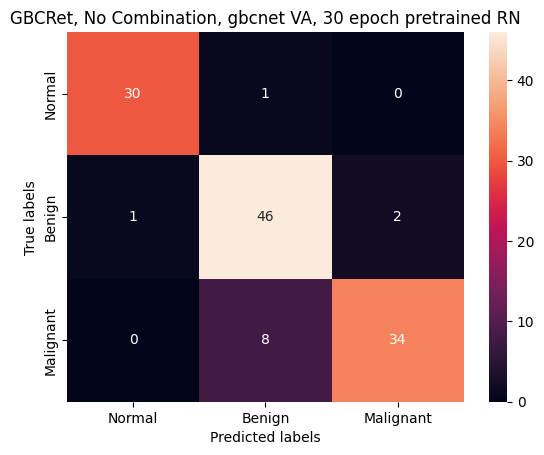

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, No Combination, gbcnet VA, 30 epoch pretrained RN')
plt.show()

### GBCRet, No Combination, gbcnet VA, 50 epoch pretrained RN

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="None"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, no combination, gbcnet VA, 50 epoch Pretrained RN/checkpoints/best_model_epoch_43.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6580765247344971, median IoU: 0.695464551448822, mAP = 0.302, mAP_50 = 0.795, mAP_75 = 0.166
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.8934 Spec: 0.9625 Sens: 0.8095


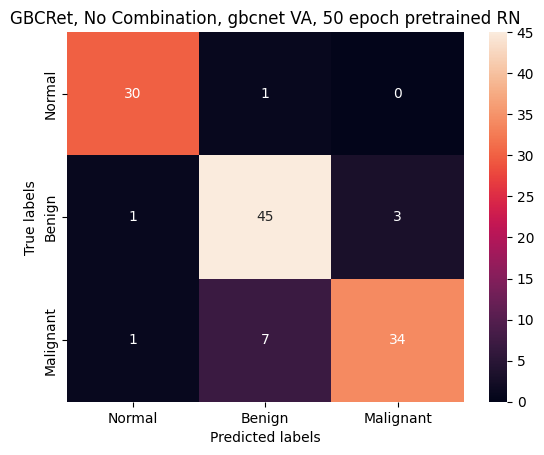

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, No Combination, gbcnet VA, 50 epoch pretrained RN')
plt.show()

### GBCRet, No Combination, gbcnet VA, 100 epoch pretrained RN
This is the result of the best model after training over 200 epochs. The results reported in the paper were obtained from the optimal epoch, which is epoch 67, considering a patience of 30 epochs.

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="None"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, no combination, gbcnet VA, 100 epoch Pretrained RN/checkpoints/best_model_epoch_110.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.659550130367279, median IoU: 0.6832026243209839, mAP = 0.307, mAP_50 = 0.801, mAP_75 = 0.155
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.9016 Spec: 0.9750 Sens: 0.8333


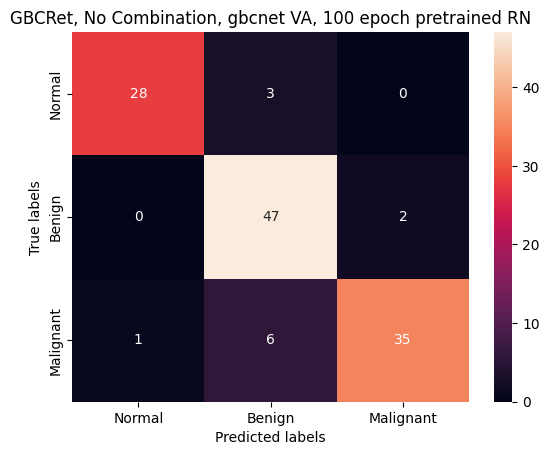

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, No Combination, gbcnet VA, 100 epoch pretrained RN')
plt.show()

### GBCRet, Layer 1, gbcnet VA, RN 50
This is the result of the best model after training over 200 epochs. The results reported in the paper were obtained from the optimal epoch, which is epoch 55, considering a patience of 30 epochs.

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer1"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, Combination layer1, gbcnet VA, 50 epoch pretrained RN/checkpoints/best_model_epoch_141.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6561865210533142, median IoU: 0.6890654563903809, mAP = 0.307, mAP_50 = 0.779, mAP_75 = 0.171
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.8934 Spec: 0.9750 Sens: 0.8095


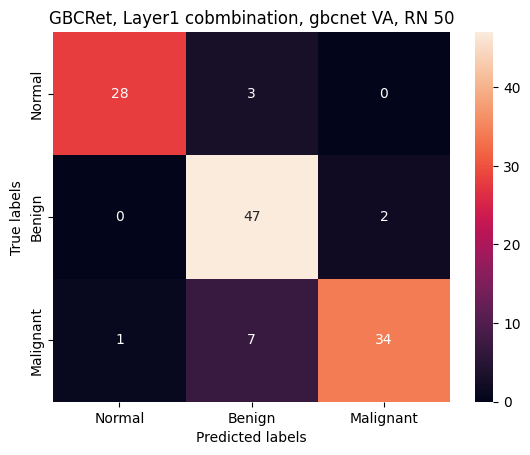

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, Layer1 cobmbination, gbcnet VA, RN 50')
plt.show()

### GBCRet, Layer 2, gbcnet VA, RN 50

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer2"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, Combination layer2, gbcnet VA, 50 epoch pretrained RN/checkpoints/best_model_epoch_43.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6574364900588989, median IoU: 0.6878405809402466, mAP = 0.305, mAP_50 = 0.794, mAP_75 = 0.162
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.8852 Spec: 0.9625 Sens: 0.7857


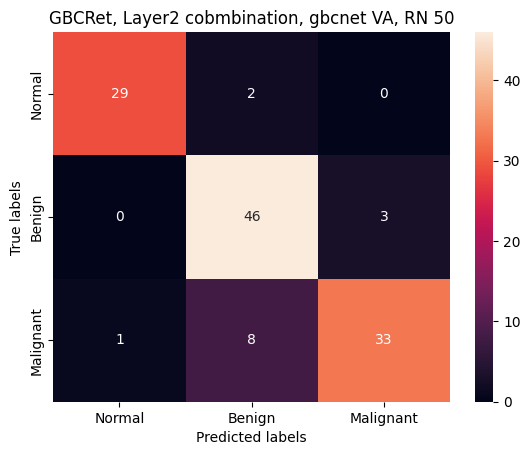

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, Layer2 cobmbination, gbcnet VA, RN 50')
plt.show()

### GBCRet, Layer 3, gbcnet VA, RN 50

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer3"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, Combination layer3, gbcnet VA, 50 epoch pretrained RN/checkpoints/best_model_epoch_44.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6602466106414795, median IoU: 0.6965856552124023, mAP = 0.314, mAP_50 = 0.808, mAP_75 = 0.168
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.8525 Spec: 0.9625 Sens: 0.6905


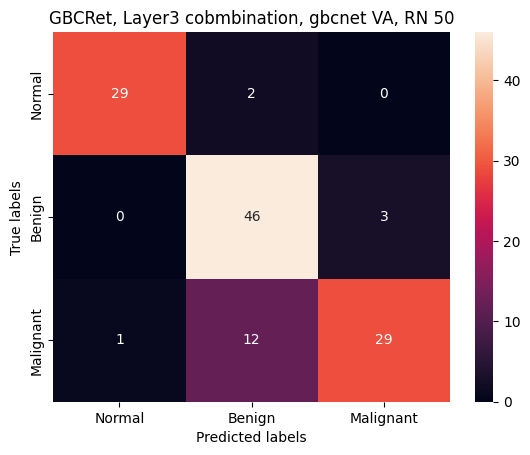

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, Layer3 cobmbination, gbcnet VA, RN 50')
plt.show()

### GBCRet, Layer 4, gbcnet VA, RN 50
This is the result of the best model after training over 200 epochs. The results reported in the paper were obtained from the optimal epoch, which is epoch 43, considering a patience of 30 epochs.

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, Combination layer4, gbcnet VA, 50 epoch pretrained RN/checkpoints/best_model_epoch_75.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6592575907707214, median IoU: 0.6941011548042297, mAP = 0.313, mAP_50 = 0.809, mAP_75 = 0.154
TP: 117, FN: 0, FP: 5
Precision: 0.9590163934426229
Recall: 1.0
Acc: 0.8770 Spec: 0.9875 Sens: 0.7143


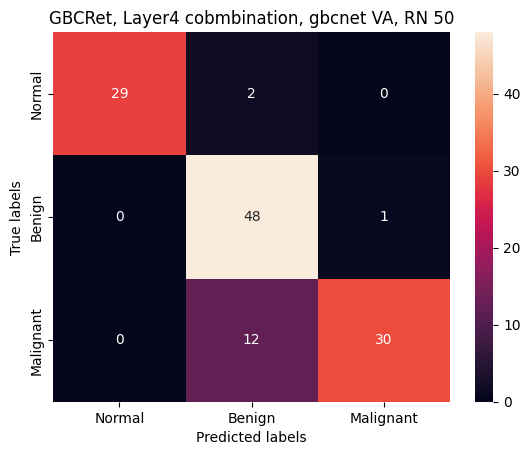

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, Layer4 cobmbination, gbcnet VA, RN 50')
plt.show()

### GBCRet, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, binary entropy loss

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="None"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN/checkpoints/best_model_epoch_37.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6405605673789978, median IoU: 0.6759586930274963, mAP = 0.282, mAP_50 = 0.746, mAP_75 = 0.145
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.8770 Spec: 0.9500 Sens: 0.7857


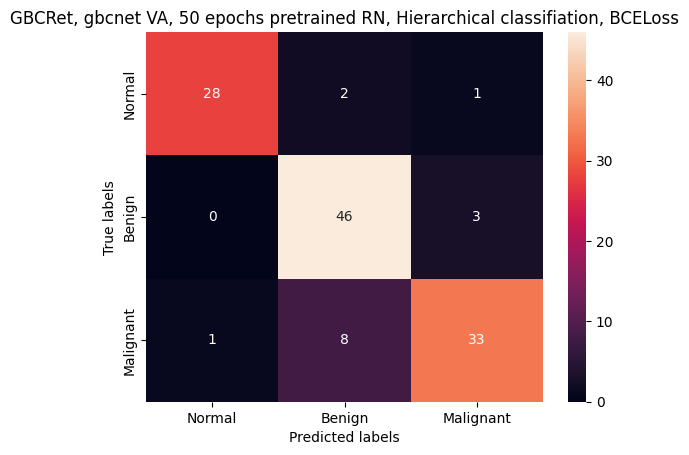

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, BCELoss')
plt.show()

### GBCRet, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, cross entropy loss

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="None"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss/checkpoints/best_model_epoch_43.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6532207131385803, median IoU: 0.6906358003616333, mAP = 0.303, mAP_50 = 0.761, mAP_75 = 0.139
TP: 119, FN: 0, FP: 3
Precision: 0.9754098360655737
Recall: 1.0
Acc: 0.8852 Spec: 0.9125 Sens: 0.8571


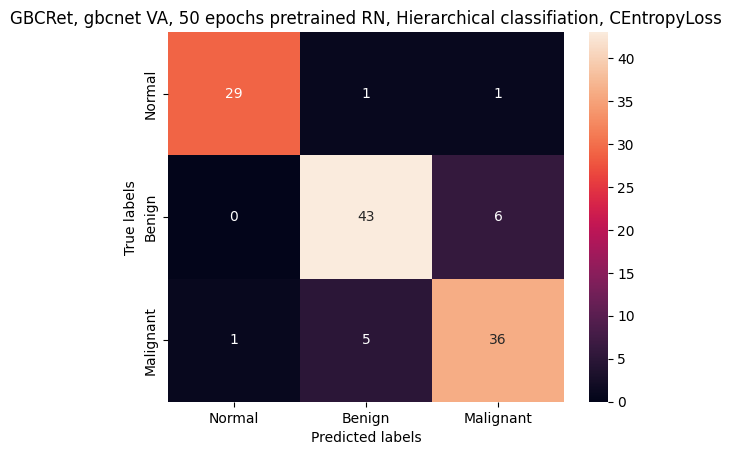

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, CEntropyLoss')
plt.show()

### GBCRet, layer4 combination, Hierarchical classifiation dropout=0.4

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, return_logits=True).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss/checkpoints/best_model_epoch_44.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6521246433258057, median IoU: 0.6848047375679016, mAP = 0.29, mAP_50 = 0.765, mAP_75 = 0.156
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.9098 Spec: 0.9750 Sens: 0.8571


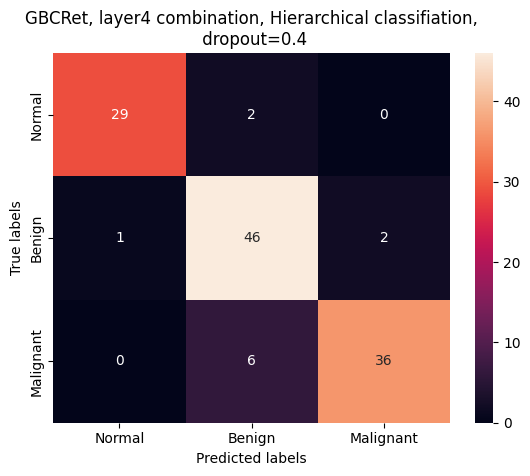

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.4')
plt.show()

### GBCRet, layer4 combination, Hierarchical classifiation dropout=0.5

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, return_logits=True).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5/checkpoints/best_model_epoch_35.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.649829626083374, median IoU: 0.6860803365707397, mAP = 0.292, mAP_50 = 0.768, mAP_75 = 0.149
TP: 117, FN: 0, FP: 5
Precision: 0.9590163934426229
Recall: 1.0
Acc: 0.9098 Spec: 0.9250 Sens: 0.9048


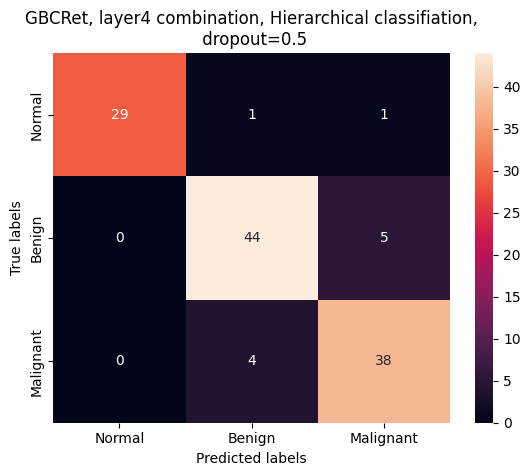

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.5')
plt.show()

### GBCRet, layer4 combination, Hierarchical classifiation dropout=0.6

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, return_logits=True).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.6/checkpoints/best_model_epoch_35.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.651375949382782, median IoU: 0.673351526260376, mAP = 0.288, mAP_50 = 0.764, mAP_75 = 0.153
TP: 118, FN: 0, FP: 4
Precision: 0.9672131147540983
Recall: 1.0
Acc: 0.9098 Spec: 0.9500 Sens: 0.8571


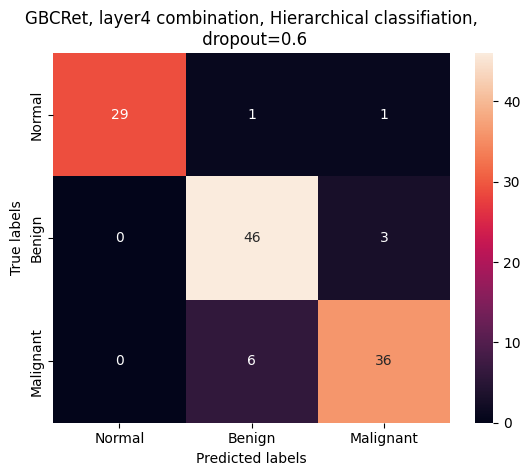

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.6')
plt.show()

### GBCRet, layer4 combination, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, criterion = nn.CrossEntropyLoss(), dropout=0.5, with attention

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = False # Apply attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="1"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, bm_fc_layers=bm_fc_layers).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, with attention/checkpoints/best_model_epoch_35.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes = evaluate_model(gbcret, val_loader, return_bboxes=True)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:01<00:00, 116MB/s]


Retinanet's COCO pre-trained weights are loaded.
Self attention is applied on combined features.
mIoU = 0.6522068381309509, median IoU: 0.6847713589668274, mAP = 0.294, mAP_50 = 0.77, mAP_75 = 0.147
TP: 117, FN: 0, FP: 5
Precision: 0.9590163934426229
Recall: 1.0
Acc: 0.9180 Spec: 0.9500 Sens: 0.8810
 Normal vs Not Noraml Acc: 0.983607 Benign vs Malignant Acc: 0.912088


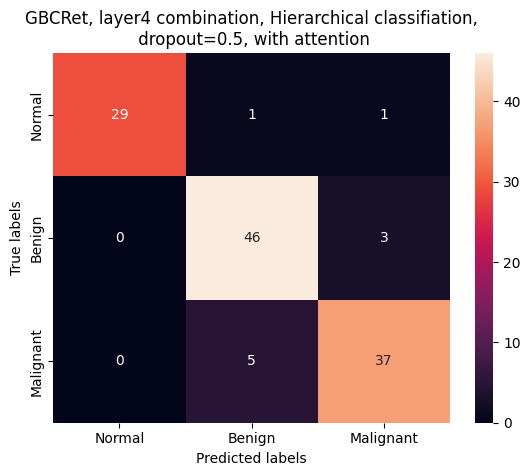

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.5, with attention')
plt.show()

### GBCRet, layer4 combination, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, criterion = nn.CrossEntropyLoss(), dropout=0.5, bm_fc_layers="2"

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="2"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=2/checkpoints/best_model_epoch_70.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6428935527801514, median IoU: 0.67383873462677, mAP = 0.293, mAP_50 = 0.764, mAP_75 = 0.169
TP: 115, FN: 0, FP: 7
Precision: 0.9426229508196722
Recall: 1.0
Acc: 0.9180 Spec: 0.9750 Sens: 0.8571


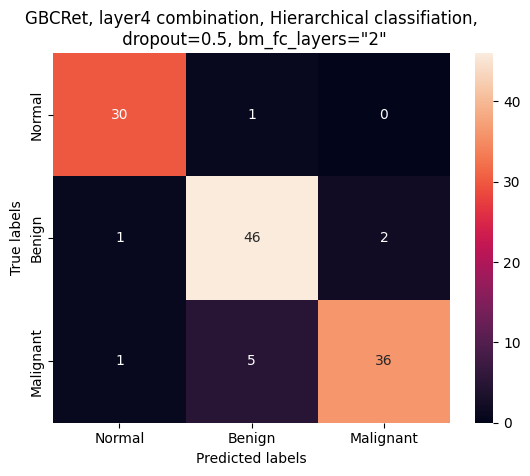

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.5, bm_fc_layers="2"')
plt.show()

### GBCRet, layer4 combination, gbcnet VA, 50 epochs pretrained RN, Hierarchical classifiation, criterion = nn.CrossEntropyLoss(), dropout=0.5, bm_fc_layers="3"

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="3"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

checkpoint = torch.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_51.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:00<00:00, 159MB/s]


Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6586982607841492, median IoU: 0.6912716031074524, mAP = 0.311, mAP_50 = 0.797, mAP_75 = 0.175
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571


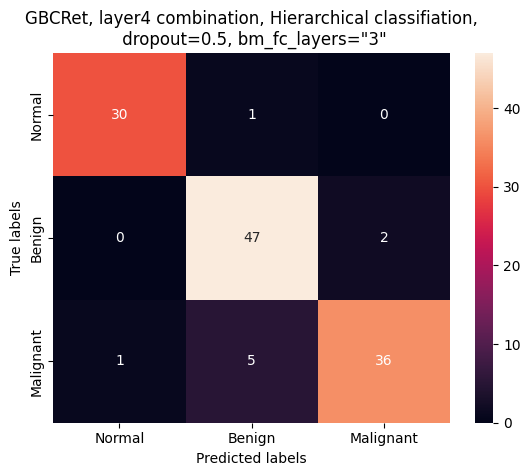

In [ ]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.5, bm_fc_layers="3"')
plt.show()

### best model's weights test

In [14]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="3"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum, retinanet_backbone=retinanet_backbone,
                         width=width, height=height, min_size=min_size, max_size=max_size, no_attn=no_attn,
                         do_hierarchical_cls=do_hierarchical_cls, bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

checkpoint = torch.load("/content/drive/MyDrive/best_gbcret.pth", map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

acc, mAP, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6586982607841492, median IoU: 0.6912720203399658, mAP = 0.311, mAP_50 = 0.797, mAP_75 = 0.175
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571


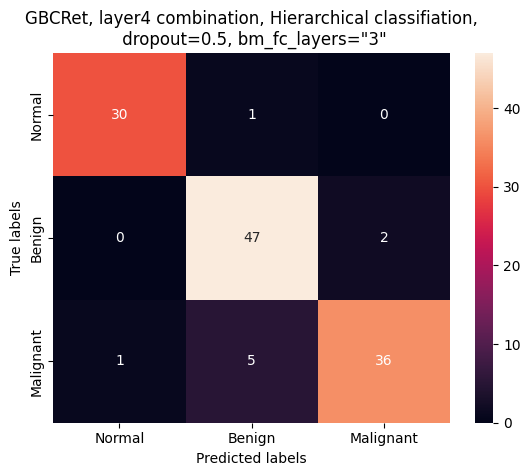

In [15]:
import seaborn as sns

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GBCRet, layer4 combination, Hierarchical classifiation,\n dropout=0.5, bm_fc_layers="3"')
plt.show()